## Install Packages



In [ ]:
# ! git clone https://github.com/oxcsml/geomstats.git
! pip3 install ./geomstats
! pip3 install jax matplotlib diffrax flax einops tqdm wandb seaborn
#! pip3 install matplotlib==3.1.3 

In [1]:
#%matplotlib inline

## Data

Setting up the utilities to generate random real numbers $\nu \in (0, 10)$ as well as a random maximum denominator $q_{max}$ are sampled. Once these are chosen, two integers $p, q$ with $ q \le q_{max}$ are chosen such that $\frac{p}{q} \approx \nu$.

Currently representing the integers $p, q$ in binary. This may be subject to change. 

In [1]:
from dataclasses import dataclass
from fractions import Fraction
from random import choice, choices
import numpy as np


def int_to_binary(x, width=14):
    return np.array(list(np.binary_repr(x, width=width)), dtype=np.uint8)


@dataclass
class RationalApprox:
    target_real: str
    frac: Fraction
    dtype = np.uint32

    @property
    def numerator(self):
        return self.frac.numerator

    @property
    def denominator(self):
        return self.frac.denominator

    def approximation(self):
        num = self.frac.numerator * 1.
        denom = self.frac.denominator
        return num / denom

    def to_numpy(self):
        num = int_to_binary(self.numerator)
        denom = int_to_binary(self.denominator)
        return np.stack((num, denom))

    def for_batch(self):
        return self.target_real, self.to_numpy()


def rand_frac(decimal_places=15, max_denom=1024):
    # TODO: Refactor this to be in terms of numpy or jax rng for proper reproducibility
    digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    leading_digit = choices(digits, weights=[4, 1, 1, 1, 1, 1, 1, 1, 1, 1])[0]
    remaining = ''.join(choices(digits, k=decimal_places))
    number = f'{leading_digit}.{remaining}'
    return RationalApprox(number, Fraction(number).limit_denominator(max_denom))


def make_batch(batch_size=128):
    denominators = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
    numbers = [rand_frac(max_denom=choice(denominators)).for_batch() for _ in range(batch_size)]
    dec_strings, fractions = zip(*numbers)
    return np.array(dec_strings, dtype=np.float32), np.stack(fractions, axis=0)

## Manifold Random Walks


In [2]:
import os

os.environ["GEOMSTATS_BACKEND"] = "jax"

import jax
import jax.numpy as jnp
import diffrax

In [3]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.product_manifold import ProductSameManifold, ProductSameRiemannianMetric
import geomstats.backend as gs

INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:Using jax backend


In [4]:
def geodesic_random_walk(manif, num_steps, time, rng_key, x0=None):
    step_size = time / num_steps
    gamma = jnp.sqrt(step_size)
    tangent_dim = manif.embedding_space.dim
    if x0 is None:
        rng_key, x0_key = jax.random.split(rng_key)
        x0 = manif.random_uniform(state=x0_key)
    def grw_step(carry, rv):
        tangent_rv = gamma * manif.to_tangent(rv, carry)
        x_new = manif.exp(tangent_rv, carry)
        return x_new, x_new
    rvs = jax.random.normal(rng_key, (num_steps, tangent_dim))
    _, path = jax.lax.scan(grw_step, x0, rvs)
    return path

In [5]:
x = jnp.array([0., 1., 0.])
key = jax.random.PRNGKey(314)
key, subkey = jax.random.split(key)
manif = Hypersphere(2)
grw = geodesic_random_walk(manif, 1000, 8, subkey, x0=x)

In [6]:
import geomstats.visualization as visualization
#import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns


def remove_background(ax):
    ax.set_axis_off()
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    return ax


def latlon_from_cartesian(points):
    r = jnp.linalg.norm(points, axis=-1)
    x = points[..., 0]
    y = points[..., 1]
    z = points[..., 2]

    lat = -jnp.arcsin(z / r)
    lon = jnp.arctan2(y, x)
    # lon = jnp.where(lon > 0, lon - math.pi, lon + math.pi)
    return jnp.concatenate([jnp.expand_dims(lat, -1), jnp.expand_dims(lon, -1)], axis=-1)


def cartesian_from_latlong(points):
    lat = points[..., 0]
    lon = points[..., 1]

    x = jnp.cos(lat) * jnp.cos(lon)
    y = jnp.cos(lat) * jnp.sin(lon)
    z = jnp.sin(lat)

    return jnp.stack([x, y, z], axis=-1)


def get_spherical_grid(N, eps=0.0):
    lat = jnp.linspace(-90 + eps, 90 - eps, N // 2)
    lon = jnp.linspace(-180 + eps, 180 - eps, N)
    Lat, Lon = jnp.meshgrid(lat, lon)
    latlon_xs = jnp.concatenate([Lat.reshape(-1, 1), Lon.reshape(-1, 1)], axis=-1)
    spherical_xs = jnp.pi * (latlon_xs / 180.0) + jnp.array([jnp.pi / 2, jnp.pi])[None, :]
    xs = Hypersphere(2).spherical_to_extrinsic(spherical_xs)
    return xs, lat, lon


def plot_3d(x0s, xts, size, prob):
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111, projection="3d")
    ax = remove_background(ax)
    fig.subplots_adjust(left=-0.2, bottom=-0.2, right=1.2, top=1.2, wspace=0, hspace=0)
    # ax.view_init(elev=30, azim=45)
    ax.view_init(elev=0, azim=0)
    cmap = sns.cubehelix_palette(as_cmap=True)
    sphere = visualization.Sphere()
    sphere.draw(ax, color="red", marker=".")
    # sphere_plot(ax)
    # sphere.plot_heatmap(ax, pdf, n_points=16000, alpha=0.2, cmap=cmap)
    for k, (x0, xt) in enumerate(zip(x0s, xts)):
        if x0 is not None:
            cax = ax.scatter(x0[:, 0], x0[:, 1], x0[:, 2], s=50, color="green")
        if xt is not None:
            x, y, z = xt[:, 0], xt[:, 1], xt[:, 2]
            c = prob if prob is not None else np.ones([*xt.shape[:-1]])
            cax = ax.scatter(x, y, z, s=50, vmin=0.0, vmax=2.0, c=c, cmap=cmap)
        # if grad is not None:
        #     u, v, w = grad[:, 0], grad[:, 1], grad[:, 2]
        #     quiver = ax.quiver(
        #         x, y, z, u, v, w, length=0.2, lw=2, normalize=False, cmap=cmap
        #     )
        #     quiver.set_array(c)

    plt.colorbar(cax)
    # plt.savefig(out, dpi=dpi, bbox_inches="tight", transparent=True)
    plt.close(fig)
    return fig

In [7]:
grw = geodesic_random_walk(manif, 200, 8, subkey, x0=x)

In [8]:
x0 = jnp.array([0., 0., 1.])
jnp.tile(x0, (400, 1))

DeviceArray([[0., 0., 1.],
             [0., 0., 1.],
             [0., 0., 1.],
             ...,
             [0., 0., 1.],
             [0., 0., 1.],
             [0., 0., 1.]], dtype=float32)

In [9]:
vgrw = jax.vmap(geodesic_random_walk, in_axes=(None, None, None, 0, 0))
keys = jnp.stack(jax.random.split(subkey, 5000))
path = vgrw(manif, 200, 2, keys, jnp.tile(x0, (5000, 1)))

In [10]:
path[:, 199, :].shape

(5000, 3)

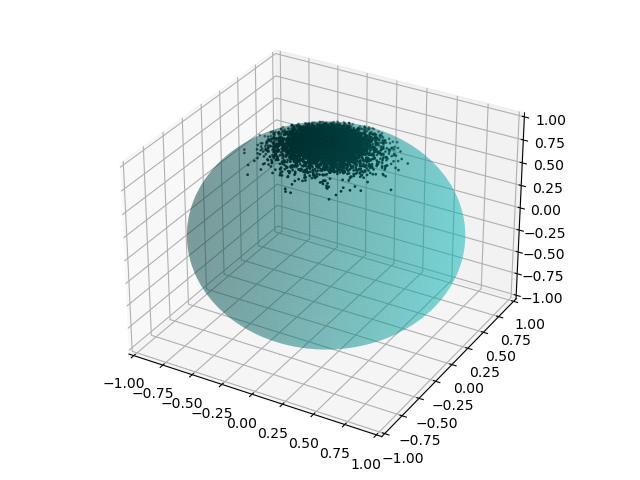

In [11]:
%matplotlib widget
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

#Import data


#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)
p = path[:, 2,:]
ax.scatter(p[:, 0], p[:, 1], p[:, 2], color="k",s=1)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.tight_layout()


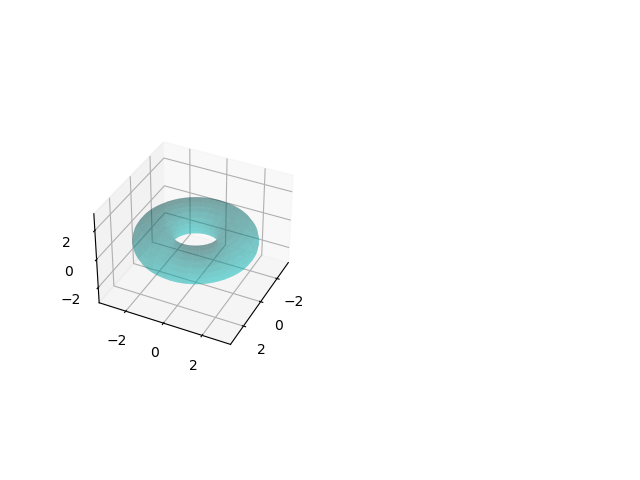

In [13]:
n = 100

theta = np.linspace(0, 2.*np.pi, n)
phi = np.linspace(0, 2.*np.pi, n)
theta, phi = np.meshgrid(theta, phi)
c, a = 2, 1
x = (c + a*np.cos(theta)) * np.cos(phi)
y = (c + a*np.cos(theta)) * np.sin(phi)
z = a * np.sin(theta)

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_zlim(-3,3)
ax1.plot_surface(x, y, z, rstride=5, cstride=5, color='c', alpha=0.3, linewidth=0)
ax1.view_init(36, 26)


In [20]:
manif.exp(3 * manif.to_tangent(jnp.array([1., 1., 1]), x0), x0)

DeviceArray([-0.6305145 , -0.6305145 , -0.45266205], dtype=float32)

In [16]:
x0

DeviceArray([0., 0., 1.], dtype=float32)